<a href="https://colab.research.google.com/github/Ryan-Siglag/NBA-Score-Prediction/blob/main/NBA_Totals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Datasets**

In [124]:
import kagglehub
import pandas as pd
import os

In [125]:
path = kagglehub.dataset_download("cviaxmiwnptr/nba-betting-data-october-2007-to-june-2024")
print("Path to dataset files:", path)
print(os.listdir(path))

Using Colab cache for faster access to the 'nba-betting-data-october-2007-to-june-2024' dataset.
Path to dataset files: /kaggle/input/nba-betting-data-october-2007-to-june-2024
['nba_2008-2025.csv']


In [126]:
df = pd.read_csv(os.path.join(path, 'nba_2008-2025.csv'))

In [127]:
path = kagglehub.dataset_download("pablote/nba-enhanced-stats")
print("Path to dataset files:", path)
print(os.listdir(path))

Using Colab cache for faster access to the 'nba-enhanced-stats' dataset.
Path to dataset files: /kaggle/input/nba-enhanced-stats
['2017-18_standings.csv', 'metadata_playerBoxScore.pdf', '2016-17_standings.csv', '2017-18_officialBoxScore.csv', 'metadata_teamBoxScore.pdf', '2012-18_standings.csv', '2017-18_teamBoxScore.csv', 'metadata_standing.pdf', '2012-18_teamBoxScore.csv', 'metadata_officialBoxScore.pdf', '2012-18_playerBoxScore.csv', '2012-18_officialBoxScore.csv', '2016-17_playerBoxScore.csv', 'teamBoxScore.csv', '2017-18_playerBoxScore.csv', '2016-17_teamBoxScore.csv', '2016-17_officialBoxScore.csv']


In [128]:
box_score_df = pd.read_csv(os.path.join(path, '2012-18_teamBoxScore.csv'))

In [129]:
df.head()

,season,date,regular,playoffs,away,home,score_away,score_home,q1_away,q2_away,...,ot_home,whos_favored,spread,total,moneyline_away,moneyline_home,h2_spread,h2_total,id_spread,id_total
0,2008,2007-10-30,True,False,por,sa,97,106,26,23,...,0,home,13.0,189.5,900.0,-1400.0,5.0,95.0,0.0,1
1,2008,2007-10-30,True,False,utah,gs,117,96,28,34,...,0,home,1.0,212.0,100.0,-120.0,3.0,105.5,0.0,1
2,2008,2007-10-30,True,False,hou,lal,95,93,16,27,...,0,away,5.0,199.0,-230.0,190.0,3.0,99.0,0.0,0
3,2008,2007-10-31,True,False,phi,tor,97,106,22,28,...,0,home,6.5,191.0,255.0,-305.0,2.0,96.5,1.0,1
4,2008,2007-10-31,True,False,wsh,ind,110,119,23,22,...,16,away,1.5,203.5,-125.0,105.0,1.0,105.0,0.0,1


In [130]:
box_score_df.head()

,gmDate,gmTime,seasTyp,offLNm1,offFNm1,offLNm2,offFNm2,offLNm3,offFNm3,teamAbbr,...,opptFIC40,opptOrtg,opptDrtg,opptEDiff,opptPlay%,opptAR,opptAST/TO,opptSTL/TO,poss,pace
0,2012-10-30,19:00,Regular,Brothers,Tony,Smith,Michael,Workman,Haywoode,WAS,...,61.6667,105.6882,94.4447,11.2435,0.4390,16.7072,1.0476,33.3333,88.9409,88.9409
1,2012-10-30,19:00,Regular,Brothers,Tony,Smith,Michael,Workman,Haywoode,CLE,...,56.0417,94.4447,105.6882,-11.2435,0.3765,18.8679,2.0000,84.6154,88.9409,88.9409
2,2012-10-30,20:00,Regular,McCutchen,Monty,Wright,Sean,Fitzgerald,Kane,BOS,...,80.8333,126.3381,112.6515,13.6866,0.5244,19.8287,3.1250,100.0000,94.9832,94.9832
3,2012-10-30,20:00,Regular,McCutchen,Monty,Wright,Sean,Fitzgerald,Kane,MIA,...,62.7083,112.6515,126.3381,-13.6866,0.4643,18.8501,1.5000,25.0000,94.9832,94.9832
4,2012-10-30,22:30,Regular,Foster,Scott,Zielinski,Gary,Dalen,Eric,DAL,...,58.6458,99.3678,108.1034,-8.7356,0.5000,18.6567,1.7143,42.8571,91.5790,91.5790


In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23118 entries, 0 to 23117
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   season          23118 non-null  int64  
 1   date            23118 non-null  object 
 2   regular         23118 non-null  bool   
 3   playoffs        23118 non-null  bool   
 4   away            23118 non-null  object 
 5   home            23118 non-null  object 
 6   score_away      23118 non-null  int64  
 7   score_home      23118 non-null  int64  
 8   q1_away         23118 non-null  int64  
 9   q2_away         23118 non-null  int64  
 10  q3_away         23118 non-null  int64  
 11  q4_away         23118 non-null  int64  
 12  ot_away         23118 non-null  int64  
 13  q1_home         23118 non-null  int64  
 14  q2_home         23118 non-null  int64  
 15  q3_home         23118 non-null  int64  
 16  q4_home         23118 non-null  int64  
 17  ot_home         23118 non-null 

**Merge Datasets**

In [132]:
box_score_df['teamAbbr'] = box_score_df['teamAbbr'].str.lower()

In [133]:
box_score_df[['gmDate', 'teamAbbr', 'teamEFG%', 'pace']].head()


,gmDate,teamAbbr,teamEFG%,pace
0,2012-10-30,was,0.4000,88.9409
1,2012-10-30,cle,0.5000,88.9409
2,2012-10-30,bos,0.5600,94.9832
3,2012-10-30,mia,0.5949,94.9832
4,2012-10-30,dal,0.5000,91.5790


In [134]:
home_stats = box_score_df.rename(columns={
    'gmDate' : 'date',
    'teamAbbr': 'home',
    'teamEFG%': 'home_eFG%',
    'pace': 'home_pace'
})

away_stats = box_score_df.rename(columns={
    'gmDate' : 'date',
    'teamAbbr': 'away',
    'teamEFG%': 'away_eFG%',
    'pace': 'away_pace'
})

In [135]:
df = df.merge(
    home_stats,
    on=['date', 'home'],
    how='left'
)
df = df.merge(
    away_stats,
    on=['date', 'away'],
    how='left'
)

In [136]:
df[['home_eFG%', 'away_eFG%', 'home_pace', 'away_pace']].isna().mean()
df = df.dropna(
    subset=['home_eFG%', 'away_eFG%', 'home_pace', 'away_pace']
)

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5949 entries, 6329 to 14126
Columns: 269 entries, season to away_pace
dtypes: bool(2), float64(215), int64(14), object(38)
memory usage: 12.2+ MB


In [138]:
df.head()

,season,date,regular,playoffs,away,home,score_away,score_home,q1_away,q2_away,...,opptFIC40_y,opptOrtg_y,opptDrtg_y,opptEDiff_y,opptPlay%_y,opptAR_y,opptAST/TO_y,opptSTL/TO_y,poss_y,away_pace
6329,2013,2012-10-30,True,False,bos,mia,107,120,25,29,...,80.8333,126.3381,112.6515,13.6866,0.5244,19.8287,3.1250,100.0000,94.9832,94.9832
6330,2013,2012-10-30,True,False,dal,lal,99,91,25,23,...,58.6458,99.3678,108.1034,-8.7356,0.5000,18.6567,1.7143,42.8571,91.5790,91.5790
6331,2013,2012-10-31,True,False,ind,tor,90,88,27,21,...,55.7292,96.1075,98.2918,-2.1843,0.3837,14.1332,1.8000,120.0000,91.5641,91.5641
6332,2013,2012-10-31,True,False,den,phi,75,84,22,16,...,58.4375,89.0099,79.4731,9.5368,0.3448,14.0362,1.1250,81.2500,94.3715,94.3715
6333,2013,2012-10-31,True,False,hou,det,105,96,27,28,...,58.3333,101.5159,111.0330,-9.5171,0.4118,16.4783,1.3125,75.0000,94.5665,94.5665


**Create Rolling Features**

In [139]:
recent_avg = 10  # Number of previous games to compute recent averages

#Filter regular season
df_reg = df[df["regular"] == True].copy()

#Format date
df_reg["date"] = pd.to_datetime(df_reg["date"])

# Sort so rolling windows work correctly (team-by-team, by date)
df_reg = df_reg.sort_values(["season", "date"])

In [140]:
#Format data to gather info on home and away teams
home_df = df_reg[["season", "date", "home", "away", "score_home", "score_away", "home_eFG%", "home_pace"]].rename(
    columns={"home": "team", "away": "opponent", "score_home": "score", "score_away": "allowed", "home_eFG%": "EFG", "home_pace": "pace"}
)

away_df = df_reg[["season", "date", "away", "home", "score_away", "score_home", "away_eFG%", "away_pace"]].rename(
    columns={"away": "team", "home": "opponent", "score_away": "score", "score_home": "allowed", "away_eFG": "EFG", "away_pace": "pace"}
)

scores = pd.concat([home_df, away_df], ignore_index=True)
scores = scores.sort_values(["team", "season", "date"])
scores.head()

,season,date,team,opponent,score,allowed,EFG,pace,away_eFG%
12,2013,2012-11-02,atl,hou,102,109,0.5118,97.3819,NaN
5979,2013,2012-11-04,atl,okc,104,95,NaN,90.6683,0.5422
42,2013,2012-11-07,atl,ind,89,86,0.4770,90.1803,NaN
56,2013,2012-11-09,atl,mia,89,95,0.4753,89.3600,NaN
6020,2013,2012-11-11,atl,lac,76,89,NaN,89.8544,0.4792


In [141]:
scores["recent_avg_score"] = (
    scores.groupby(["season", "team"])["score"]
        .transform(lambda s: s.shift(1).rolling(recent_avg).mean())
)

scores["recent_avg_allowed"] = (
    scores.groupby(["season", "team"])["allowed"]
          .transform(lambda s: s.shift(1).rolling(recent_avg).mean())
)

In [142]:
opp_allowed = scores[["team", "date", "recent_avg_allowed", "recent_avg_score"]].copy()
opp_allowed = opp_allowed.rename(columns={
    "team": "opponent",
    "recent_avg_allowed": "opponent_recent_avg_allowed",
    "recent_avg_score": "opponent_recent_avg_score",
})

scores = scores.merge(
    opp_allowed,
    on=["opponent", "date"],
    how="left"
)

In [143]:
scores["score_diff"] = scores["score"] - scores["opponent_recent_avg_allowed"]
scores["recent_avg_score_diff"] = (
    scores.groupby("team")["score_diff"]
          .shift(1)
          .rolling(window=recent_avg, min_periods=1)
          .mean()
          .reset_index(level=0, drop=True)
)

In [144]:
scores["recent_efg"] = (
    scores.groupby("team")["EFG"]
          .shift(1)
          .rolling(window=recent_avg, min_periods=1)
          .mean()
          .reset_index(level=0, drop=True)
)


In [145]:
scores["recent_pace"] = (
    scores.groupby("team")["pace"]
          .shift(1)
          .rolling(window=recent_avg, min_periods=1)
          .mean()
          .reset_index(level=0, drop=True)
)

In [146]:
def add_rolling_features(df_reg, scores, features):
    """
    Add rolling features such as recent_avg_score or recent_avg_allowed
    back into the main df_reg.

    df_reg: main game-level dataframe (home/away)
    scores: long-format team logs (team, date, feature columns)
    features: list of feature column names from scores to merge in
    """

    for feat in features:
        # HOME merge
        df_reg = df_reg.merge(
            scores[["team", "date", feat]],
            left_on=["home", "date"],
            right_on=["team", "date"],
            how="left"
        ).rename(columns={feat: f"{feat}_home"})

        df_reg = df_reg.drop(columns=["team"])  # drop temporary merge key

        # AWAY merge
        df_reg = df_reg.merge(
            scores[["team", "date", feat]],
            left_on=["away", "date"],
            right_on=["team", "date"],
            how="left"
        ).rename(columns={feat: f"{feat}_away"})

        df_reg = df_reg.drop(columns=["team"])  # drop again

    return df_reg


In [147]:
df_reg = add_rolling_features(
    df_reg=df_reg,
    scores=scores,
    features=[
        "recent_avg_score", "recent_avg_allowed", "recent_avg_score_diff",
        "recent_efg", "recent_pace"
        ]
)

In [148]:
df_reg["total_scored_expected"] = ( #Expected score based on both teams' offenses
    df_reg["recent_avg_score_home"] + df_reg["recent_avg_score_away"]
)

df_reg["total_allowed_expected"] = ( #Expected score based on both teams' defenses
    df_reg["recent_avg_allowed_home"] + df_reg["recent_avg_allowed_away"]
)

In [149]:
df_reg["target"] = df_reg["score_away"] + df_reg["score_home"] #Actual final score

In [150]:
df_reg = df_reg.dropna()

In [151]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5017 entries, 140 to 5948
Columns: 282 entries, season to target
dtypes: bool(2), datetime64[ns](1), float64(227), int64(15), object(37)
memory usage: 10.8+ MB


**Models**

In [152]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, mean_absolute_error
from sklearn.model_selection import train_test_split

In [169]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [154]:
#Separate by date to avoid leakage
train = df_reg[df_reg['date'] < '2017-10-01']
test  = df_reg[df_reg['date'] >= '2017-10-01']

Number Prediction Model

In [158]:
num_features = ["total_scored_expected", "total_allowed_expected",  "recent_efg_home", "recent_efg_away", "recent_pace_home", "recent_pace_away"]
num_target = "target"

In [159]:
num_model = RandomForestRegressor(n_estimators=200, random_state=20)
num_model.fit(train[num_features], train[num_target])

RandomForestRegressor(n_estimators=200, random_state=20)

In [167]:
pred = num_model.predict(test[num_features])
print("Betting Line Mean Absolute Error:", mean_absolute_error(test[num_target], test["total"]) )
print("Model Mean Absolute Error:", mean_absolute_error(test[num_target], pred))
print("True Total Standard Deviation", test[num_target].std())

#Interperatation: The number prediction is not quite as accurate as the betting total prediction, but it is more accurate than guessing the average.

Betting Line Mean Absolute Error: 14.605263157894736
Model Mean Absolute Error: 15.602691387559808
True Total Standard Deviation 20.131497914037592


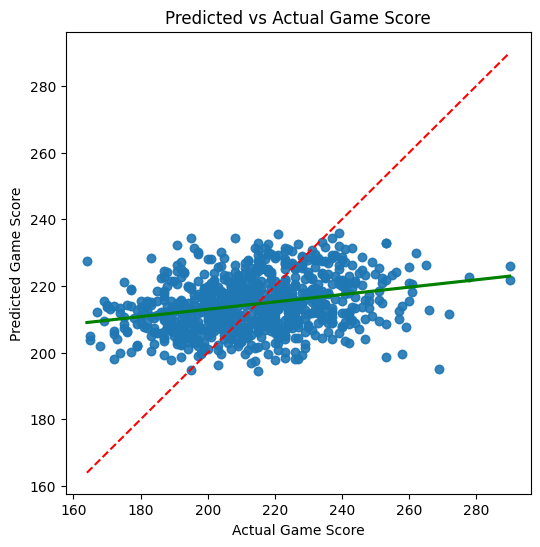

In [170]:
plt.figure(figsize=(6,6))
plt.scatter(test[num_target], pred, alpha=0.5)
plt.plot([test[num_target].min(), test[num_target].max()],
         [test[num_target].min(), test[num_target].max()],
         'r--')  # y=x line

sns.regplot(x=test[num_target], y=pred, ci=None, line_kws={"color": "green"})

plt.xlabel('Actual Game Score')
plt.ylabel('Predicted Game Score')
plt.title('Predicted vs Actual Game Score')
plt.show()

Classification Model (Compared to Total Betting Line)

In [155]:
features = ["total", "recent_avg_score_diff_away", "recent_avg_score_diff_home", "recent_avg_score_diff_away", "recent_efg_home", "recent_efg_away", "recent_pace_home", "recent_pace_away"]
target = "id_total"

In [156]:
model = RandomForestClassifier(
    n_estimators=200, #Number of trees
    max_depth=None, #Let them grow freely
    random_state=20
)

In [157]:
model.fit(train[features], train[target])

RandomForestClassifier(n_estimators=200, random_state=20)

In [164]:
pred = model.predict(test[features])
print("Accuracy:", accuracy_score(test[target], pred))

Accuracy: 0.48086124401913877


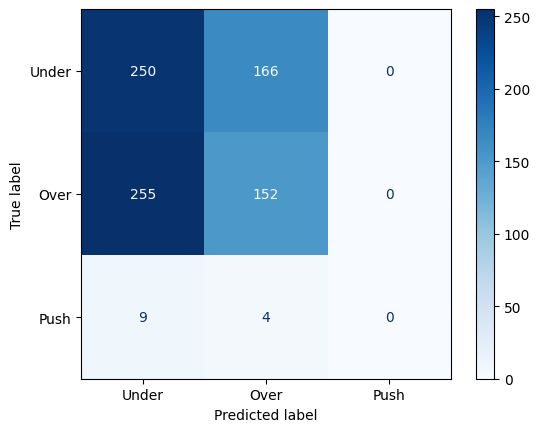

In [165]:
cm = confusion_matrix(test[target], pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Under","Over","Push"])
disp.plot(cmap=plt.cm.Blues)
plt.show()